In [1]:
import time
import math
import torch 
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider
from torch import nn, optim
from torch.utils.data import Dataset as TorchDataset, DataLoader
from qml.dataset import StockGANDataset
from datetime import datetime, timezone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from qiskit import QuantumCircuit
from qiskit_aer import AerProvider
from qiskit_aer.noise import NoiseModel
from qiskit.primitives import BackendEstimator
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_algorithms.utils import algorithm_globals
from qiskit_ibm_runtime import QiskitRuntimeService
from IPython.display import clear_output

In [2]:
aer_provider = AerProvider()
azure_provider = AzureQuantumProvider(
    Workspace(
        resource_id="/subscriptions/422cf85a-5643-4ef0-bafa-2809a5aa27e0/resourceGroups/qml/providers/Microsoft.Quantum/Workspaces/stockqgan", 
        location="eastus"
    )
)
ibm_service = QiskitRuntimeService(channel="ibm_quantum", token="ac6000c560e92b674e0ebbaa683a55dceabb7aa1017e57b5c2f2ce865bebb29e719a8b90180a5d335b0e0fa0698e43ba35c0b76e89bd5dab1fba6cd657c65f71")

# Create Aer simulator backend
aer_backend = aer_provider.get_backend("qasm_simulator")

# Create Rigetti simulator and QPU backends
rigetti_simulator_backend = azure_provider.get_backend("rigetti.sim.qvm")
rigetti_qpu_backend = azure_provider.get_backend("rigetti.qpu.ankaa-2")

# Create an IBM backend
ibm_backend = ibm_service.least_busy(operational=True, simulator=False)

# Get the noise model from an actual quantum machine
noise_model = NoiseModel.from_backend(ibm_backend)

backend = rigetti_simulator_backend

In [3]:
algorithm_globals.random_seed = 1337
_ = torch.manual_seed(1337)

In [4]:
DATASET_DIR = "../../datasets"
OUTPUT_DIR = "qvm_sim_pca_4"

TICKERS = [
    "AAPL", # Apple
    "AMD",  # Advanced Micro Devices
    "AMZN", # Amazon
    "COST", # Costco
    "GOOG", # Google
    "INTC", # Intel
    "META", # Meta (Facebook)
    "NFLX", # Netflix
    "NVDA", # Nvidia
    "TSM",  # TSMC
    "YM=F", # Dow Jones Index
    "^NDX", # Nasdaq Index
    "^SPX", # Standard & Poor 500 Index
    "TSLA", # Tesla
]
TARGET = "AAPL"

In [5]:
# Download the stock prices, note that some parameters here does not matter since we will be pre-processing our data with a custom class later
dataset = StockGANDataset(
    tickers=TICKERS,
    target_ticker=TARGET,
    start=datetime(year=2023, month=1, day=1, tzinfo=timezone.utc),
    end=datetime(year=2024, month=1, day=1, tzinfo=timezone.utc),
    interval="1d",
    sliding_window=1,          # does not matter 
    train_test_pct=(0.8, 0.2), # does not matter
    root=DATASET_DIR
)

In [6]:
dataset.data

timestamp,AAPL,AMD,AMZN,COST,GOOG,INTC,META,NFLX,NVDA,TSM,YM=F,^NDX,^SPX,TSLA
"datetime[ns, America/New_York]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-01-03 00:00:00 EST,124.216293,64.019997,85.82,439.224792,89.699997,26.044006,124.607788,294.950012,143.079773,72.324837,33278.0,10862.639648,3824.139893,108.099998
2023-01-04 00:00:00 EST,125.497498,64.660004,85.139999,442.403076,88.709999,26.969629,127.235008,309.410004,147.417679,74.562096,33416.0,10914.799805,3852.969971,113.639999
2023-01-05 00:00:00 EST,124.166649,62.330002,83.120003,436.23056,86.769997,26.852707,126.805458,309.700012,142.580048,73.985687,33070.0,10741.219727,3808.100098,110.339996
2023-01-06 00:00:00 EST,128.735245,63.959999,86.080002,467.897278,88.160004,27.992682,129.882202,315.549988,148.517136,76.271782,33772.0,11040.349609,3895.080078,113.059998
2023-01-09 00:00:00 EST,129.261627,67.239998,87.360001,463.905029,88.800003,28.557795,129.332779,315.170013,156.203354,78.460182,33670.0,11108.450195,3892.090088,119.769997
2023-01-10 00:00:00 EST,129.837677,68.050003,89.870003,466.472839,89.239998,28.68446,132.849045,327.540009,159.011963,79.398071,33849.0,11205.780273,3919.25,118.849998
2023-01-11 00:00:00 EST,132.578842,69.059998,95.089996,469.292603,92.260002,29.083939,132.749146,327.26001,159.931519,79.896324,34110.0,11402.519531,3969.610107,123.220001
2023-01-12 00:00:00 EST,132.499374,70.800003,95.269997,467.470886,91.910004,29.512648,136.565109,330.130005,165.029037,84.996094,34319.0,11459.610352,3983.169922,123.559998
2023-01-13 00:00:00 EST,133.840134,71.0,98.120003,470.203461,92.800003,29.337267,136.834808,332.820007,168.907135,84.800697,34416.0,11541.480469,3999.090088,122.400002


In [7]:
class Dataset(TorchDataset):
    def __init__(self, data: pl.DataFrame):
        self.in_scaler = MinMaxScaler(feature_range=(0, 1))
        self.out_scaler = MinMaxScaler(feature_range=(0, 1))

        train_data, test_data = train_test_split(
            dataset.data.drop("timestamp").to_numpy(), 
            train_size=0.8, 
            shuffle=False, # must not shuffle timeseries data
        )
        self.train_x, self.train_y = (
            torch.from_numpy(self.in_scaler.fit_transform(PCA(n_components=4).fit_transform(train_data))).float(), 
            torch.from_numpy(self.out_scaler.fit_transform(train_data.T[0].reshape(-1, 1))).float(),
        )
        self.test_x, self.test_y = (
            torch.from_numpy(self.in_scaler.fit_transform(PCA(n_components=4).fit_transform(test_data))).float(),
            torch.from_numpy(self.out_scaler.fit_transform(test_data.T[0].reshape(-1, 1))).float(),
        )

    def __len__(self):
        return self.train_x.shape[0]

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.train_x[index], self.train_y[index]

dataset = Dataset(data=dataset.data)

In [8]:
num_features = dataset.train_x.shape[1]

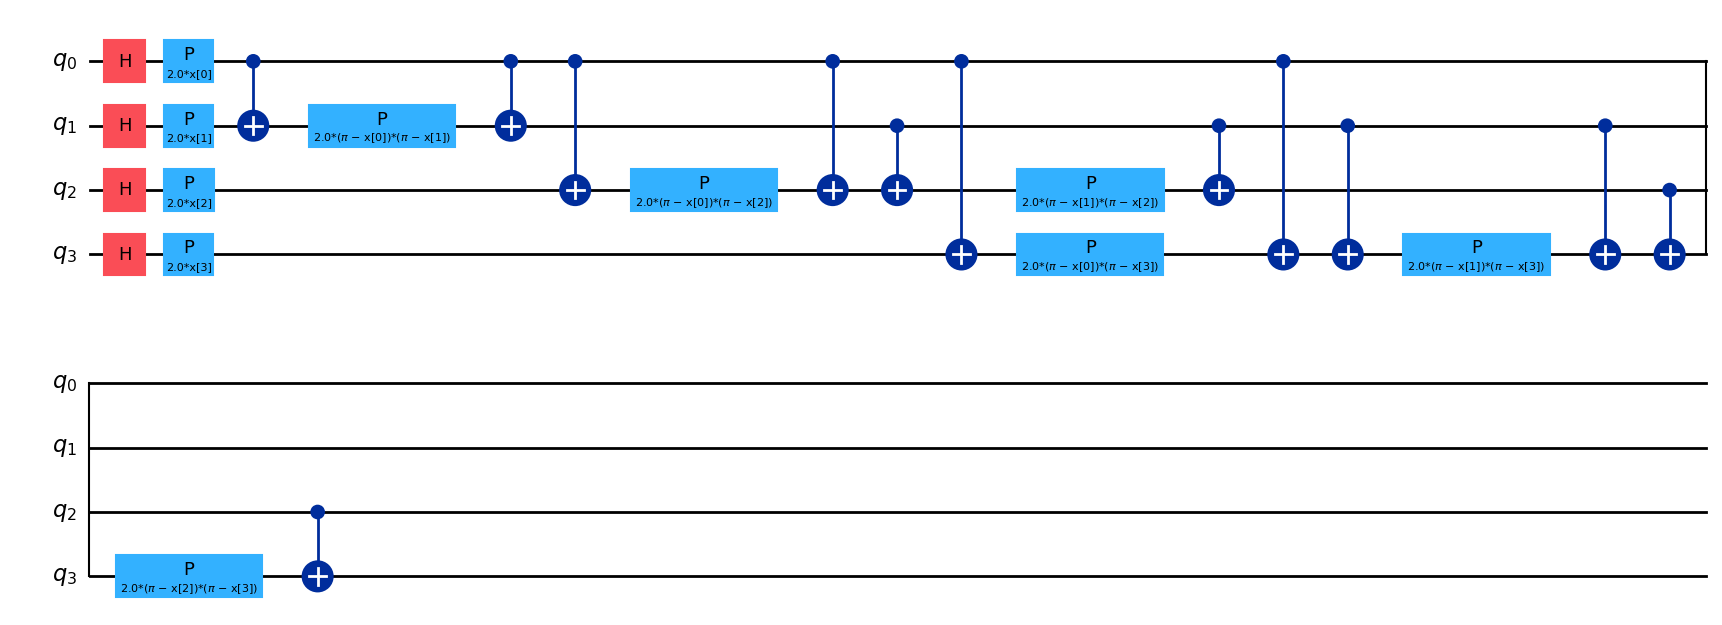

In [9]:
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw('mpl')

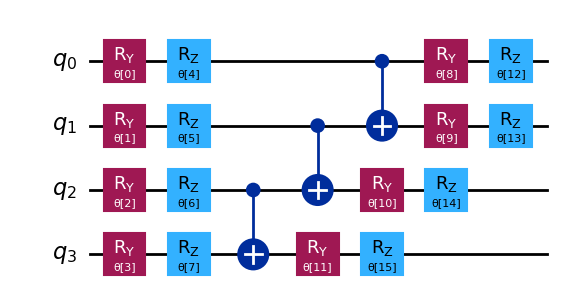

In [10]:
ansatz = EfficientSU2(num_qubits=num_features, reps=1)
ansatz.decompose().draw('mpl')

In [11]:
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

In [12]:
shots = 10000
estimator = BackendEstimator(
    backend=backend,
    options={
        "shots": shots, 
        "seed": algorithm_globals.random_seed,
        "noise_model": noise_model,
    } if backend == aer_backend else {"shots": shots}
)

def create_generator() -> nn.Module:
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=estimator,
        input_params=qc.input_parameters,
        weight_params=qc.weight_parameters,
    )
    initial_weights = algorithm_globals.random.random(qc.num_weight_parameters)
    return TorchConnector(qnn, initial_weights)

class Discriminator(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, 32, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding='same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding='same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3: Tensor = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

In [13]:
def plot_training_progress(generator_loss_values, discriminator_loss_values):
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend()
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()
    
    plt.show()

In [ ]:
EPOCHS = 10
LEARNING_RATE = 0.01
BETAS = (0.0, 0.9)
BATCH_SIZE = 125

device = torch.device("cpu")

generator, discriminator = create_generator(), Discriminator(1)

loss = nn.BCELoss()
g_optim, d_optim = (
    optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=BETAS),
    optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=BETAS)
)

dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE)

g_losses, d_losses = [], []

start = time.time()

for epoch in range(EPOCHS):
    epoch_start = time.time()
    g_local_losses, d_local_losses = [], []

    print(f"in epoch {epoch}")

    # Get next batch of data from the dataloder
    for i, (x, y) in enumerate(dataloader):
        print(f"in batch {i}")
        x = x.to(device)
        y = y.to(device)

        # Generate fake data
        print(f"{datetime.now()}: generating fake data")
        fake_data = generator(x)

        # Train the discriminator to understand true labels
        print(f"{datetime.now()}: discriminating true labels")
        d_real_output = discriminator(y.unsqueeze(1))
        real_labels = torch.ones_like(d_real_output).to(device)
        d_loss_real = loss(d_real_output, real_labels)

        # Train the discriminator to understand false label
        print(f"{datetime.now()}: discriminating false labels")
        d_fake_output = discriminator(fake_data.unsqueeze(1))
        fake_labels = torch.zeros_like(real_labels).to(device)
        d_loss_fake = loss(d_fake_output, fake_labels)

        # Optimise the discriminator loss
        d_loss = (d_loss_real + d_loss_fake)
        discriminator.zero_grad()
        print(f"{datetime.now()}: backpropagating discriminator")
        d_loss.backward(retain_graph=True)
        d_optim.step()
        d_local_losses.append(d_loss.item())

        # Optimise the generator loss
        print(f"{datetime.now()}: discriminating false labels")
        d_fake_output = discriminator(fake_data.unsqueeze(1))
        g_loss = loss(d_fake_output, real_labels)
        generator.zero_grad()
        print(f"{datetime.now()}: backpropagating generator")
        g_loss.backward()
        g_optim.step()
        g_local_losses.append(g_loss.item()) 

    g_losses.append(sum(g_local_losses))
    d_losses.append(sum(d_local_losses))

    plot_training_progress(g_losses, d_losses)
    epoch_elapsed = time.time() - epoch_start
    print(f"Epoch {epoch + 1} took {epoch_elapsed:.2f} seconds: g_loss={sum(g_local_losses):.2f} d_loss={sum(d_local_losses):.2f}")

elapsed = time.time() - start
print(f"Trained in {elapsed:0.2f} seconds")

torch.save(generator.state_dict(), f"{OUTPUT_DIR}/stock_qgan_generator")
torch.save(discriminator.state_dict(), f"{OUTPUT_DIR}/stock_qgan_discriminator")

in epoch 0
in batch 0
2024-04-24 22:08:59.763004: generating fake data
..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................2024-04-24 22:34:40.912378: discriminating true labels
2024-04-24 22:34:40.986095: discriminating false labels
2024-04-24 22:34:40.996257: backpropagating discriminator


Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.


In [ ]:
plt.plot(g_losses, label='Generator')
plt.plot(d_losses, label='Discriminator', color='orange')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc='center left')

In [ ]:
generator.eval()
pred_y_train: torch.Tensor = generator(dataset.train_x)
pred_y_test: torch.Tensor = generator(dataset.test_x)

y_train_true = dataset.out_scaler.inverse_transform(dataset.train_y.reshape(-1, 1))
y_train_pred = dataset.out_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = dataset.out_scaler.inverse_transform(dataset.test_y.reshape(-1, 1))
y_test_pred = dataset.out_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Actual Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
R2 = r2_score(y_train_true, y_train_pred)
print(f'Training dataset\nRMSE: {RMSE}\nR2: {R2}')

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Actual Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction test dataset')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
R2 = r2_score(y_test_true, y_test_pred)
print(f'Test dataset\nRMSE: {RMSE}\nR2: {R2}')

In [ ]:
np.savetxt(f"{OUTPUT_DIR}/stock_qgan_g_losses.txt", g_losses, delimiter=',')
np.savetxt(f"{OUTPUT_DIR}/stock_qgan_d_losses.txt", d_losses, delimiter=',')
np.savetxt(f"{OUTPUT_DIR}/stock_qgan_y_train_true.txt", y_train_true, delimiter=',')
np.savetxt(f"{OUTPUT_DIR}/stock_qgan_y_train_pred.txt", y_train_pred, delimiter=',')
np.savetxt(f"{OUTPUT_DIR}/stock_qgan_y_test_true.txt", y_test_true, delimiter=',')
np.savetxt(f"{OUTPUT_DIR}/stock_qgan_y_test_pred.txt", y_test_pred, delimiter=',')